Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

'1.14.0'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
# assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Train RNN model with CTC loss on the generated emnist-lines dataset

From Keras examples [image_ocr.py](https://github.com/keras-team/keras/blob/master/examples/image_ocr.py) and [Chengwei's post](https://www.dlology.com/blog/how-to-train-a-keras-model-to-recognize-variable-length-text/) helped me a lot in getting the ctc loss working correctly.

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
# To be able to write code as if this notebook was one level up in files tree structure.
sys.path.append('..')

from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops import ctc_ops
from tensorflow.python.ops import math_ops as tf_math_ops

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

import pandas as pd
from PIL import Image

In [4]:
from recognizer.datasets import Dataset
from recognizer.datasets import EmnistDataset
from recognizer.networks import lenet
from recognizer.networks import simple
from recognizer.networks import NetworkInput

Hyperparameters

In [5]:
batch_size = 128
epochs = 10

In [6]:
model_save_path = Path("../recognizer/weights/lines_ctc_loss.h5")

## Load characters mapping

In [7]:
import json

with open(Dataset.raw_data_path()/"emnist"/"emnist_essentials.json") as json_file:  
    mapping = json.load(json_file)["mapping"]
    mapping = {m[0]: m[1] for m in mapping}
    mapping[62] = ' '
    mapping[63] = '_'
    
mapping_reversed = {v: k for k, v in mapping.items()}

## Build the new model

In [8]:
char_image_height = 28
char_image_width = 28
max_length = 34
num_classes = 64
image_height = char_image_height
image_width = char_image_width * max_length

input_shape = (image_height, image_width)
output_shape = (max_length, num_classes)

window_width: float = 16
window_stride: float = 8
    
num_windows = ((image_width - window_width) // window_stride) + 1
if num_windows < max_length:
    raise ValueError(f'Window width/stride need to generate >= {max_length} windows (currently {num_windows})')

In [9]:
def slide_window(image, window_width, window_stride):
    """
    Takes (image_height, image_width, 1) input,
    Returns (num_windows, image_height, window_width, 1) output, where
    num_windows is floor((image_width - window_width) / window_stride) + 1
    """
    patches = tf.image.extract_image_patches(image, 
                                             sizes=[1, 1, window_width, 1], 
                                             strides=[1, 1, window_stride, 1], 
                                             rates=[1, 1, 1, 1], 
                                             padding='VALID')
    patches = tf.transpose(patches, (0, 2, 1, 3))
    patches = tf.expand_dims(patches, -1)
    
    return patches

In [10]:
window_width = 12
window_stride = 5

image_input = layers.Input(shape=input_shape, name='image')
image_reshaped = layers.Reshape((image_height, image_width, 1))(image_input)

image_patches = layers.Lambda(
    slide_window,
    arguments={'window_width': window_width, 'window_stride': window_stride}
)(image_reshaped)

In [11]:
image_patches

<tf.Tensor 'lambda/ExpandDims:0' shape=(?, 189, 28, 12, 1) dtype=float32>

### The model

In [12]:
# the actual loss calc occurs here despite it not being an internal Keras loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [13]:
convnet_base = lenet(NetworkInput(input_shape=(image_height, window_width, 1), number_of_classes=num_classes))
convnet_base.layers

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
# Get rid of the last two layers (dropout and softmax)
convnet = KerasModel(inputs=convnet_base.inputs, outputs=convnet_base.layers[-2].output)
time_distributed_outputs = layers.TimeDistributed(convnet)(image_patches)

# Try a single lstm
# rnn_outputs = layers.CuDNNLSTM(128, return_sequences=True)(time_distributed_outputs)  # layers.LSTM(128, return_sequences=True)(time_distributed_outputs)

# Try one GRU layer
# rnn_outputs = layers.CuDNNGRU(256, return_sequences=True)(time_distributed_outputs)

# Try two layers of bidirectional GRUs
rnn_outputs = layers.Bidirectional(layers.CuDNNGRU(128, return_sequences=True))(time_distributed_outputs)
rnn_outputs = layers.Bidirectional(layers.CuDNNGRU(64, return_sequences=True))(rnn_outputs)

y_pred = layers.Dense(num_classes, activation='softmax', name='softmax_output')(rnn_outputs)
KerasModel(inputs=image_input, outputs=y_pred).summary()

# Add ctc specific ipnuts for the training model, the predication model will just need access to `image_input`
labels = layers.Input(name='the_labels', shape=[max_length], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

model = KerasModel(inputs=[image_input, labels, input_length, label_length], outputs=loss_out)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(optimizer=sgd, loss={'ctc': lambda y_true, y_pred: y_pred})

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 952)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 952, 1)        0         
_________________________________________________________________
lambda (Lambda)              (None, 189, 28, 12, 1)    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 189, 128)          412160    
___________________________________

## Build the generators

In [15]:
df = pd.read_csv(Dataset.processed_data_path()/"emnist_lines"/"data.csv")

output_length = len(df)

In [16]:
df.head()

,image,sentence
0,0.png,Whats wrong at state _____________
1,1.png,The transducer itself moves the __
2,2.png,There is an ancient and venerable
3,3.png,They destroyed a trading house ___
4,4.png,Alec waited a moment on guard ___


Shuffle the data and reset their index

In [17]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image,sentence
0,2336.png,It was all set up so there would _
1,8293.png,The latter now furnishes the area
2,230.png,He looked at her out of himself __
3,2934.png,The Latin for example was not ____
4,3139.png,Where to file ___________________


In [18]:
# # For the sake of debugging let us test only one sentence
# df = df.iloc[[0] * len(df)]
# df

Split data into train and valid

In [19]:
valid_length = int(len(df) * .2)

train_df = df.iloc[valid_length:]
valid_df = df.iloc[:valid_length]

## Train it

In [20]:
class LinesDataSequence(Sequence):
    
    def __init__(self, df, batch_size=32):
        self.df = df
        self.batch_size = batch_size

    def __len__(self):
        return len(self.df) // batch_size

    def __getitem__(self, idx):
        """Return a single batch."""
        X_data = np.ones([self.batch_size, image_height, image_width])

        labels = np.ones([self.batch_size, max_length])
        input_length = np.zeros([self.batch_size, 1])
        label_length = np.zeros([self.batch_size, 1])
        
        for i in range(self.batch_size):
            index = i + idx
            row = self.df.iloc[index]
            
            image = Image.open(Dataset.processed_data_path()/"emnist_lines"/row['image'])
            image = np.array(image).astype(np.float32).reshape(image_height, image_width)
            X_data[i, :, :] = image
            
            y = [mapping_reversed[char] for char in row['sentence']]
            y = to_categorical(y, num_classes).astype(np.int)
#             labels[i, :] = y
            labels[i, :] = np.argmax(y, axis=-1)
#             labels[i, :] = np.asarray(y)
            
            # input_length refers to your sequence length and label_length refers to the ground truth label length
            # TODO :: Not sure what to do with this!
            input_length[i] = 189 - 2  # 64  # 34  # 189
            
            # Find all of the indices in the label that are not blank
            empty_at = np.where(y[:, -1] == 1)[0]
            # Length of the label is the pos of the first blank, or the max length
            if empty_at.shape[0] > 0:
                label_length[i] = empty_at[0]
            else:
                label_length[i] = y.shape[0]
            
        inputs = {
            'image': X_data,
            'the_labels': labels,
            'input_length': input_length,
            'label_length': label_length
        }
        outputs = {'ctc': np.zeros([self.batch_size])}  # dummy data for dummy loss function

        return (inputs, outputs)

Check progress in TensorBoard by running `tensorboard --logdir=logs/lines_ctc_loss` in terminal

In [21]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_ctc_loss')
]

In [22]:
history = model.fit_generator(
    LinesDataSequence(train_df, batch_size),
    steps_per_epoch=len(df) // batch_size,
    validation_data=LinesDataSequence(valid_df, batch_size),
    validation_steps=len(valid_df) // batch_size,
    epochs=epochs,
    callbacks=callbacks)
history.history.keys()

Epoch 1/10
78/78 [==============================] - 58s 739ms/step - loss: 115.4028 - val_loss: 80.0431
Epoch 2/10
78/78 [==============================] - 45s 579ms/step - loss: 73.8574 - val_loss: 72.9440
Epoch 3/10
78/78 [==============================] - 45s 582ms/step - loss: 64.6830 - val_loss: 69.7381
Epoch 4/10
78/78 [==============================] - 45s 580ms/step - loss: 56.3173 - val_loss: 70.5059
Epoch 5/10
78/78 [==============================] - 45s 578ms/step - loss: 46.6542 - val_loss: 73.0654
Epoch 6/10
78/78 [==============================] - 45s 577ms/step - loss: 37.9462 - val_loss: 76.8413
Epoch 7/10
78/78 [==============================] - 45s 574ms/step - loss: 30.2049 - val_loss: 85.2798
Epoch 8/10
78/78 [==============================] - 45s 576ms/step - loss: 24.3437 - val_loss: 94.1648
Epoch 9/10
78/78 [==============================] - 45s 574ms/step - loss: 22.6326 - val_loss: 99.1836
Epoch 10/10
78/78 [==============================] - 45s 574ms/step - lo

dict_keys(['loss', 'val_loss'])

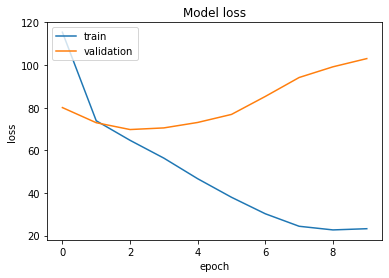

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Save the model

In [24]:
model.save(model_save_path)

## Restore the model

In [25]:
# model = keras.models.load_model(model_save_path)

# model.trainable = False
# model.compile(optimizer=sgd, loss={'ctc': lambda y_true, y_pred: y_pred})

# Load weights into the model instead

## Evaluate

In [26]:
model_pred = KerasModel(inputs=image_input, outputs=y_pred)
# model.trainable = False
# model.compile(optimizer=sgd, loss={'ctc': lambda y_true, y_pred: y_pred}, metrics=['accuracy'])
# model.load_weights(weight_file)

model_pred.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 952)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 952, 1)        0         
_________________________________________________________________
lambda (Lambda)              (None, 189, 28, 12, 1)    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 189, 128)          412160    
_________________________________________________________________
bidirectional (Bidirectional (None, 189, 256)          198144    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 189, 128)          123648    
_________________________________________________________________
softmax_output (Dense)       (None, 189, 64)           8256

In [27]:
def labels_to_text(labels):
    return "".join([mapping[c] for c in labels])

def decode_predict_ctc(out, top_paths=1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
          beam_width = top_paths
    for i in range(top_paths):
        lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
        text = labels_to_text(lables)
        results.append(text)
        
    return results
  
def predit_on_image(model, img, top_paths=1):
    batch = np.expand_dims(img, axis=0)  # Create a fake batch of one image
    net_out_value = model.predict(batch)
    top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
    
    return top_pred_texts

In [28]:
index = 0

image = Image.open(Dataset.processed_data_path()/"emnist_lines"/df.iloc[index]['image'])
image_numpy = np.array(image).astype(np.float32) / 255

# sentence = df.iloc[index]['sentence']
# y = [mapping_reversed[char] for char in sentence]
# y = to_categorical(y, num_classes).astype(np.int)
# test_batch_y = y.reshape((1,) + y.shape)

results = predit_on_image(model_pred, image_numpy, top_paths=1)
results

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


['HIe hasn oad af of to forn ahoile ']

In [29]:
image